In [1]:
%run IDM_helper_functions.ipynb

## Train IDM

In [2]:
from numpy.fft import rfft,irfft
import time
import numpy as np
from scipy.special import erf
#from scipy.linalg import circulant
import matplotlib.pyplot as plt
from scipy.optimize import minimize, curve_fit
import cProfile
import re
import matplotlib.cm as matplotlib_cm
import math
#import sys
import multiprocessing
import copy



In [10]:
                                                                                     # t-grids

NameError: name 'B' is not defined

In [15]:
# Function that simulates one trial of the time-varying drift/bound DDM
def DDM_pdf_general(params, setting_index, task_index=0):
    '''
    Now assume f_mu, f_sigma, f_Bound are callable functions
    '''
    ### Initialization
    mu_0_temp          = params[0]                                                                                      # Constant component of drift rate mu.
    param_mu_x_temp    = params[1]                                                                                      # Parameter for x_dependence of mu.
    param_mu_t_temp    = 0# params[2]                                                                                      # Parameter for t_dependence of mu.
    sigma_0_temp       = 1# params[2]                                                                                      # Constant component of noise sigma.
    param_sigma_x_temp = 0# params[4]                                                                                      # Parameter for t_dependence of sigma.
    param_sigma_t_temp = 0# params[5]                                                                                      # Parameter for t_dependence of sigma.
    B_0_temp           = params[2]                                                                                      # Constant component of drift rate mu.
    param_B_t_temp     = 0# params[7]                                                                                      # Parameter for t_dependence of B (no x-dep I sps?).
    
    
    ## additional parameters
    dx = 0.008                                                                                                              # grid size
    T_dur = 3                                                                                                              # [s] Duration of simulation
    dt = 0.005  

    x_list = np.arange(-B_0_temp, B_0_temp+0.1*dx, dx)                                                                                    # List of x-grids (Staggered-mesh)
    t_list = np.arange(0., T_dur, dt)  
    
    ## Simulation Settings
    settings = setting_list[setting_index]                                                                              # Define the condition for mu, sigma, and B, for x&t dependences.
    f_mu_setting = settings[0]                                                                                          # Declare the type of DDM model regarding mu. Need to modify f_mu_matrix and f_mu_flux.
    f_sigma_setting = settings[1]                                                                                       # Declare the type of DDM model regarding sigma. Need to modify f_sigma_matrix and f_sigma_flux.
    f_bound_setting = settings[2]                                                                                       # Declare the type of DDM model regarding boundaries. Specify on f_bound_t.
    f_IC_setting = settings[3]                                                                                          # Declare the type of Initial Condition. Specify on f_initial_condition
    ### Initialization: Lists
    t_list_temp = t_list
    pdf_list_curr = np.zeros((len(x_list)))#f_initial_condition(f_IC_setting, x_list)                                                           # Initial condition
    pdf_list_prev = np.zeros((len(x_list)))
    Prob_list_corr = np.zeros(len(t_list_temp))                                                                         # Probability flux to correct choice
    Prob_list_err = np.zeros(len(t_list_temp))                                                                          # Probability flux to erred choice
    # traj_mean_pos = np.zeros(len(t_list_temp))                                                                        # Mean position of distribution, if needed.
    ### Task specific
    param_task=0                                                                                                        # 0 if no extra active tasks/regimes/paradigms, else modify f_mu1_task.
    if len(params)>=9:
        param_task = params[8]
    task_temp = 'Fixed_Duration'# task_list[task_index]
    if task_temp == 'Duration_Paradigm':
        param_task = [params[8], mu_0_temp]
    ##### Looping through time and updating the pdf.
    for i_t in range(len(t_list_temp)-1):
        pdf_list_prev = copy.copy(pdf_list_curr)                                                                        # Update Previous state.
        mu_1_temp = f_mu1_task(t_list_temp[i_t], task_temp, param_task)                                                 # Perturbation to mu due to various tasks specified. Trivial if param_task=0
        mu_temp = mu_0_temp + mu_1_temp                                                                                 # Actual mu= drift to be used.
        if sum(pdf_list_curr[:])>0.0001:                                                                                # For efficiency only do diffusion if there's at least some densities remaining in the channel.
            ## Define the boundaries at current time.
            bound_temp = f_bound_t(B_0_temp, param_B_t_temp, t_list_temp[i_t], f_bound_setting)                         # Boundary at current time-step. Can generalize to assymetric bounds
            bound_shift = B_0_temp - bound_temp                                                                         # pre-define. Assumed bound_temp < B_0_temp (ie collapsing bounds, not increasing bounds).
            # Note that we linearly approximate the bound by the two surrounding grids sandwiching it.
            index_temp_inner = int(math.ceil(bound_shift/dx))                                                           # Index for the inner bound (smaller matrix)
            index_temp_outer = int(bound_shift/dx)                                                                      # Index for the outer bound (larger matrix)
            weight_inner    = (bound_shift - index_temp_outer*dx)/dx                                                    # The weight of the upper bound matrix, approximated linearly. 0 when bound exactly at grids.
            weight_outer    =  1. - weight_inner                                                                        # The weight of the lower bound matrix, approximated linearly.

            ## Define the diffusion matrix for implicit method
            x_list_temp = x_list[index_temp_outer:len(x_list)-index_temp_outer]                                         # List of x-positions still within bounds.
            matrix_diffusion = np.diag(np.ones(len(x_list_temp))) + f_mu_matrix(mu_temp, param_mu_x_temp, param_mu_t_temp, x_list_temp, t_list_temp[i_t], f_mu_setting) + f_sigma_matrix(sigma_0_temp, param_sigma_x_temp, param_sigma_t_temp, x_list_temp, t_list_temp[i_t], f_sigma_setting)       #Diffusion Matrix for Implicit Method. Here defined as Outer Matrix, and inder matrix is either trivial or an extracted submatrix.
            ### Compute Probability density functions (pdf)
            pdf_list_temp_outer = np.linalg.solve(matrix_diffusion  , pdf_list_prev[index_temp_outer:len(x_list)-index_temp_outer])                                                     # Probability density function for outer matrix.
            if index_temp_inner == index_temp_outer:
                pdf_list_temp_inner = copy.copy(pdf_list_temp_outer)                                                                                                                    # When bound is exactly at a grid, use the most efficient method.
            else:
                pdf_list_temp_inner = np.linalg.solve(matrix_diffusion[1:-1, 1:-1], pdf_list_prev[index_temp_inner:len(x_list)-index_temp_inner])                                       # Probability density function for inner matrix.
            Prob_list_err[i_t+1]  += weight_outer*np.sum(pdf_list_prev[:index_temp_outer])               + weight_inner*np.sum(pdf_list_prev[:index_temp_inner])                        # Pdfs out of bound is considered decisions made.
            Prob_list_corr[i_t+1] += weight_outer*np.sum(pdf_list_prev[len(x_list)-index_temp_outer:]) + weight_inner*np.sum(pdf_list_prev[len(x_list)-index_temp_inner:])              # Pdfs out of bound is considered decisions made.
            pdf_list_curr = np.zeros((len(x_list)))                                                                     # Reconstruct current proability density function, adding outer and inner contribution to it.
            pdf_list_curr[index_temp_outer:len(x_list)-index_temp_outer] += weight_outer*pdf_list_temp_outer
            pdf_list_curr[index_temp_inner:len(x_list)-index_temp_inner] += weight_inner*pdf_list_temp_inner

        else:
            break       #break if the remaining densities are too small....

        ### Increase current, transient probability of crossing either bounds, as flux
        Prob_list_corr[i_t+1] += weight_outer*pdf_list_temp_outer[-1]* ( f_mu_flux(len(x_list)-1-index_temp_outer, mu_temp, param_mu_x_temp, param_mu_t_temp, x_list, t_list_temp[i_t], f_mu_setting) + f_sigma_flux(len(x_list)-1-index_temp_outer, sigma_0_temp, param_sigma_x_temp, param_sigma_t_temp, x_list, t_list_temp[i_t], f_sigma_setting)) \
                              +  weight_inner*pdf_list_temp_inner[-1]* ( f_mu_flux(len(x_list)-1-index_temp_inner, mu_temp, param_mu_x_temp, param_mu_t_temp, x_list, t_list_temp[i_t], f_mu_setting) + f_sigma_flux(len(x_list)-1-index_temp_inner, sigma_0_temp, param_sigma_x_temp, param_sigma_t_temp, x_list, t_list_temp[i_t], f_sigma_setting))
        Prob_list_err[i_t+1]  += weight_outer*pdf_list_temp_outer[ 0]* ( f_mu_flux(              index_temp_outer, mu_temp, param_mu_x_temp, param_mu_t_temp, x_list, t_list_temp[i_t], f_mu_setting) + f_sigma_flux(              index_temp_outer, sigma_0_temp, param_sigma_x_temp, param_sigma_t_temp, x_list, t_list_temp[i_t], f_sigma_setting)) \
                              +  weight_inner*pdf_list_temp_inner[ 0]* ( f_mu_flux(              index_temp_inner, mu_temp, param_mu_x_temp, param_mu_t_temp, x_list, t_list_temp[i_t], f_mu_setting) + f_sigma_flux(              index_temp_inner, sigma_0_temp, param_sigma_x_temp, param_sigma_t_temp, x_list, t_list_temp[i_t], f_sigma_setting))
        if bound_temp < dx:                                                                                             # Renormalize when the channel size has <1 grid.
            Prob_list_corr[i_t+1] *= (1+ (1-bound_temp/dx))
            Prob_list_err[i_t+1]  *= (1+ (1-bound_temp/dx))
        # traj_mean_pos[i_t+1] = np.sum(Prob_list_corr)*1. + np.sum(Prob_list_err[:])*-1. + np.sum(pdf_list[:,i_t+1]*x_list)        # To record the mean position.

    return Prob_list_corr, Prob_list_err         

In [16]:
params = [1,0.2,1]
#setting_list[setting_index] = ['linear_xt', 'linear_xt', 'constant', 'point_source_center']
DDM_pdf_general(params = params, setting_index=0, task_index=0)

NameError: name 'f_mu1_task' is not defined

In [4]:
setting_list = [['linear_xt', 'linear_xt', 'constant', 'point_source_center'], 
                ['linear_xt', 'linear_xt', 'constant', 'point_source_center'], 
                ['linear_xt', 'linear_xt', 'constant', 'point_source_center']] 

In [5]:
setting_list[0]

['linear_xt', 'linear_xt', 'constant', 'point_source_center']

## Simulate from LCA and fit with IDM

In [69]:
x = simul_LCA_full_simp(np.tile([1,1.5,0.4], (100,1)))
print((100-sum(x[:,1]))/100)
print(x[0:10,:])


sim0
tensor(0.9800)
tensor([[1.5250, 0.0000],
        [1.2400, 0.0000],
        [2.1500, 0.0000],
        [0.8360, 0.0000],
        [3.3680, 0.0000],
        [0.7630, 0.0000],
        [1.3050, 0.0000],
        [0.8190, 0.0000],
        [2.1850, 0.0000],
        [1.9070, 0.0000]])


In [5]:
#prior_LCA = utils.BoxUniform(low=[0, 0.6, 0, 0.2], high=[1, 1.5, 0.4, 0.5])
LCA_parameters = prior.sample((20,))

n_trials = 1000
sim_num = 20

par_fitted = np.zeros((sim_num,4))

In [6]:
for i in range(sim_num):
    print(i)
    LCA_o = simul_LCA_full_simp(np.tile(LCA_parameters[i,:], (n_trials,1))) # simulate IDM data
    print(LCA_parameters[i,:])
    print(LCA_o[0:10,:])
    mnle_posterior = trainer.build_posterior(
    mcmc_method="slice_np_vectorized", mcmc_parameters=mcmc_parameters, prior = prior
    )
    
    #mnle_samples = mnle_posterior.sample((num_samples,), x=x_o) # fit with IDM
    mnle_posterior.set_default_x(LCA_o)
    mnle_map = mnle_posterior.map()
    print(np.array(mnle_map))
    par_fitted[i,:] = np.array(mnle_map)

0
sim0
tensor([0.0966, 1.0640, 0.4251, 0.2489])
tensor([[1.0069, 1.0000],
        [1.5299, 1.0000],
        [0.8419, 0.0000],
        [1.2309, 1.0000],
        [1.0509, 1.0000],
        [1.5799, 0.0000],
        [1.8369, 0.0000],
        [3.1809, 0.0000],
        [3.2489, 1.0000],
        [1.6859, 1.0000]])


C:\Users\ra36qix\Documents\GitHub\sbi\sbi\utils\sbiutils.py:316: UserWarning: An x with a batch size of 1000 was passed. It will be interpreted as a batch of independent and identically
            distributed data X={x_1, ..., x_n}, i.e., data generated based on the
            same underlying (unknown) parameter. The resulting posterior will be with
            respect to entire batch, i.e,. p(theta | X).
  warnings.warn(


[0.10026385 1.1115205  0.45711964 0.24912414]
1
sim0
tensor([0.2621, 1.3431, 0.5477, 0.4438])
tensor([[2.9468, 0.0000],
        [0.9888, 0.0000],
        [2.4718, 0.0000],
        [2.4878, 0.0000],
        [3.4438, 1.0000],
        [3.4438, 0.0000],
        [1.6328, 0.0000],
        [3.4438, 0.0000],
        [1.2748, 0.0000],
        [1.3728, 0.0000]])
[0.13881858 1.4964802  0.4327244  0.443847  ]
2
sim0
tensor([0.2472, 1.2113, 0.6954, 0.4390])
tensor([[3.4390, 0.0000],
        [3.2860, 1.0000],
        [1.0700, 0.0000],
        [2.1250, 0.0000],
        [1.0840, 0.0000],
        [3.0530, 0.0000],
        [1.7630, 0.0000],
        [1.4830, 1.0000],
        [3.4390, 0.0000],
        [3.4390, 1.0000]])
[0.17346895 1.4002783  0.4436189  0.4389969 ]
3
sim0
tensor([0.4741, 1.4668, 0.2304, 0.2072])
tensor([[2.5312, 0.0000],
        [1.1072, 0.0000],
        [3.2072, 0.0000],
        [1.1392, 0.0000],
        [2.7192, 0.0000],
        [1.3812, 0.0000],
        [3.2072, 1.0000],
        [0.572

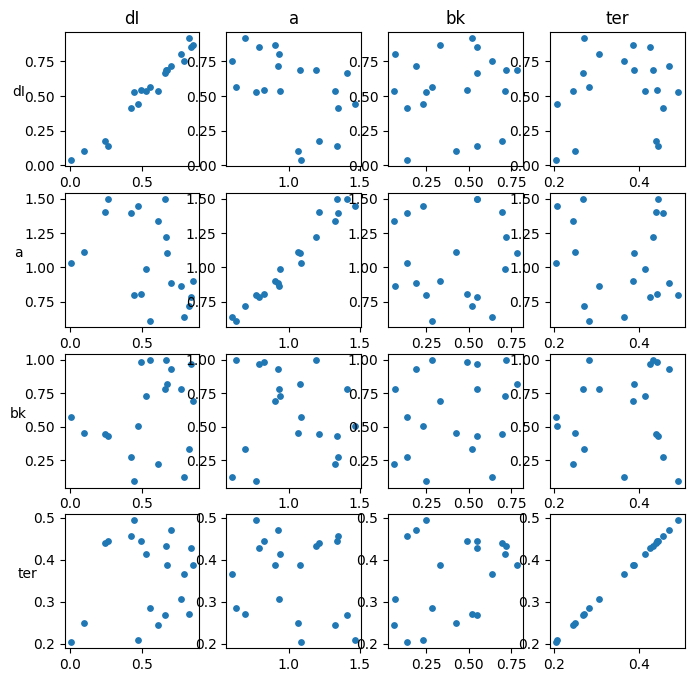

In [7]:
par_labels = ["dI","a", "bk","ter"]
par_fitted_labels = ["dI","a", "bk","ter"]
sim_fit_plot_all(LCA_parameters[:,:], par_fitted[:,:], par_labels, par_fitted_labels, 
                 s = 15, figsize=(8,8))

In [204]:
3.5*np.sqrt(0.2)

1.5652475842498528

In [3]:
# true parameters
dI = -0.5
a = 1
bk = 0.2
Ter = 0

b_new = np.sqrt(bk)*(a-dI/bk)
z_new = np.sqrt(bk)*(-dI/bk)#???
print(b_new)
print(z_new)

1.5652475842498528
1.118033988749895


In [206]:
# creat data from OU samples using the true parameters
num_simulations = 1000
prior = utils.BoxUniform(low=[0.5, 1, 0.2, 0], high=[0.5, 1, 0.2, 0])
parameters = prior.sample((num_simulations,))
x = simul_LCA_full_simp(np.array(parameters))
rts = x[x[:,1]==0][:,0]
rts.shape

sim0


torch.Size([716])

In [207]:
log_numerator.shape

torch.Size([296])

In [216]:
np.log(z_new)

0.688134638736401

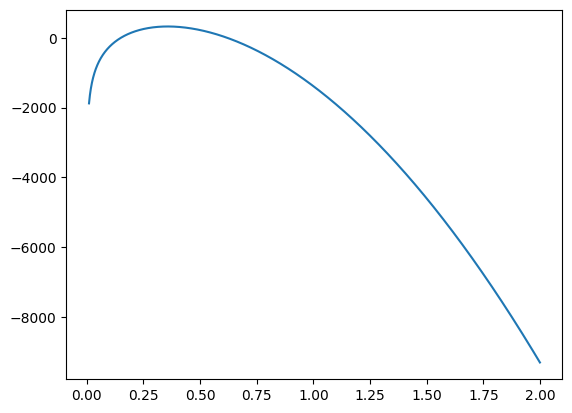

In [221]:
# calculate and plot log-likelihood against Z_new
lls = []
zs = np.arange(0.01,2,0.001)
for i in zs:
    z_new = i
    rts_new = bk*rts
    
    inside = -np.exp(-rts_new)*z_new**2/(2*np.sinh(rts_new)) + rts_new/2
    log_numerator = np.log(z_new) + inside
    denominator = np.sqrt(2*np.pi*np.sinh(rts_new)**3)

    ll = sum(log_numerator - np.log(denominator))
    lls.append(ll)

plt.plot(zs,lls)

In [118]:
def OU_loglikelihood(parameters,rts):
    
    dI, a, bk = parameters[0], parameters[1], parameters[2]
    
    z_new = np.sqrt(bk)*(a-dI/bk)
    rts_new = bk*rts
    
    inside = -np.exp(-rts_new)*z_new**2/(2*np.sinh(rts_new)) + rts_new/2
    log_numerator = np.log(z_new) + inside
    denominator = np.sqrt(2*np.pi*np.sinh(rts_new)**3)
    
    ll = sum(log_numerator - np.log(denomenator))
    return ll
    

sim0


In [140]:
num_simulations_test = 10000
lls = []
prior_test = utils.BoxUniform(low=[-1, 0.6, 0], high=[0, 1.5, 0.4])
parameters_test = prior_test.sample((num_simulations_test,))


In [141]:
for i in range(num_simulations_test):
    lls.append(OU_loglikelihood(parameters = parameters_test[i,:], rts = rts))

C:\Users\ra36qix\AppData\Local\Temp\ipykernel_12304\219888512.py:1: RuntimeWarning: invalid value encountered in log
  plt.scatter(parameters_test[:,2],np.log(lls))


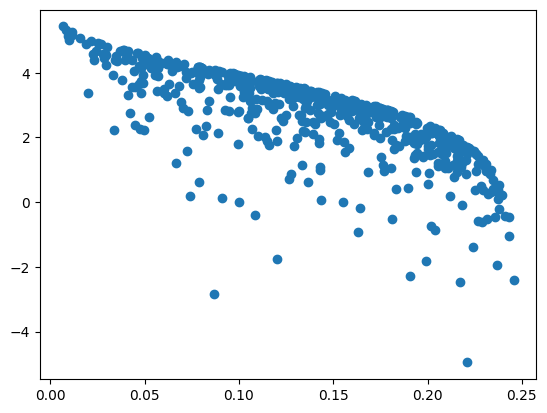

In [144]:
plt.scatter(parameters_test[:,2],np.log(lls))